In [1]:
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
with open("../dataset/train.json",'r') as f:
 json_data = json.load(f)
#print(json.dumps(json_data,indent="\t"))

In [2]:
df = pd.DataFrame({'image_id':[], "category_id":[],'Xmin':[], 'Ymin':[], 'width':[], 'height':[],
                   'ratio':[], 'area':[]})

for i,info in enumerate(json_data['annotations']):
    df.loc[i] = [
        int(info['image_id']), 
        int(info['category_id']), 
        info['bbox'][0], 
        info['bbox'][1],
        info['bbox'][2],
        info['bbox'][3],
        round(info['bbox'][2]/info['bbox'][3],1),
        info['area'],
    ]
    
print(df.head())

   image_id  category_id   Xmin   Ymin  width  height  ratio       area
0       0.0          0.0  197.6  193.7  547.8   469.7    1.2  257301.66
1       1.0          3.0    0.0  407.4   57.6   180.6    0.3   10402.56
2       1.0          7.0    0.0  455.6  144.6   181.6    0.8   26259.36
3       1.0          4.0  722.3  313.4  274.3   251.9    1.1   69096.17
4       1.0          5.0  353.2  671.0  233.7   103.4    2.3   24164.58


# 클래스 개수 분포

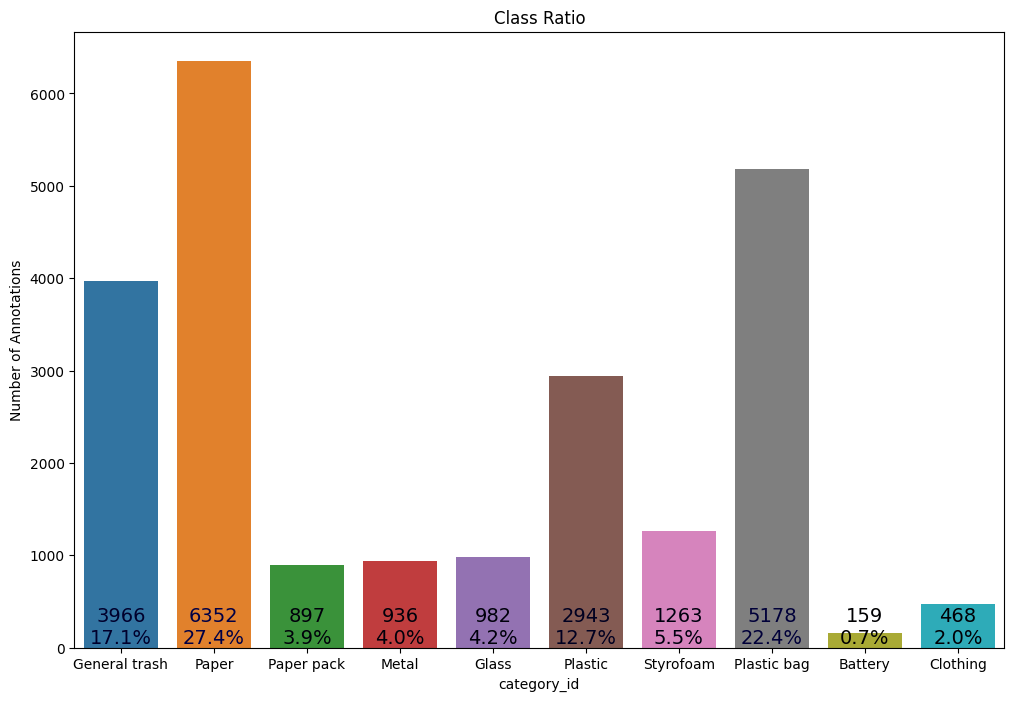

In [3]:
# category id 분포
plt.figure(figsize=(12, 8))
ax = sns.countplot(x='category_id', data=df)
plt.title("Class Ratio")
plt.ylabel("Number of Annotations")
plt.xticks(range(10), map(lambda x: x['name'], json_data['categories']))
count = df['category_id'].value_counts()
count = dict(sorted(count.items()))
for i, (cat_id, cat_count) in enumerate(count.items()):
    ratio = cat_count / sum(count.values()) * 100
    ax.text(i, 50, f'{cat_count}\n{ratio:.1f}%', ha='center', size=14, color=(0, 0, ratio / 100))
plt.show()


# 한 이미지 당 Bbox 개수 세기

최소값: 1 최대값: 71


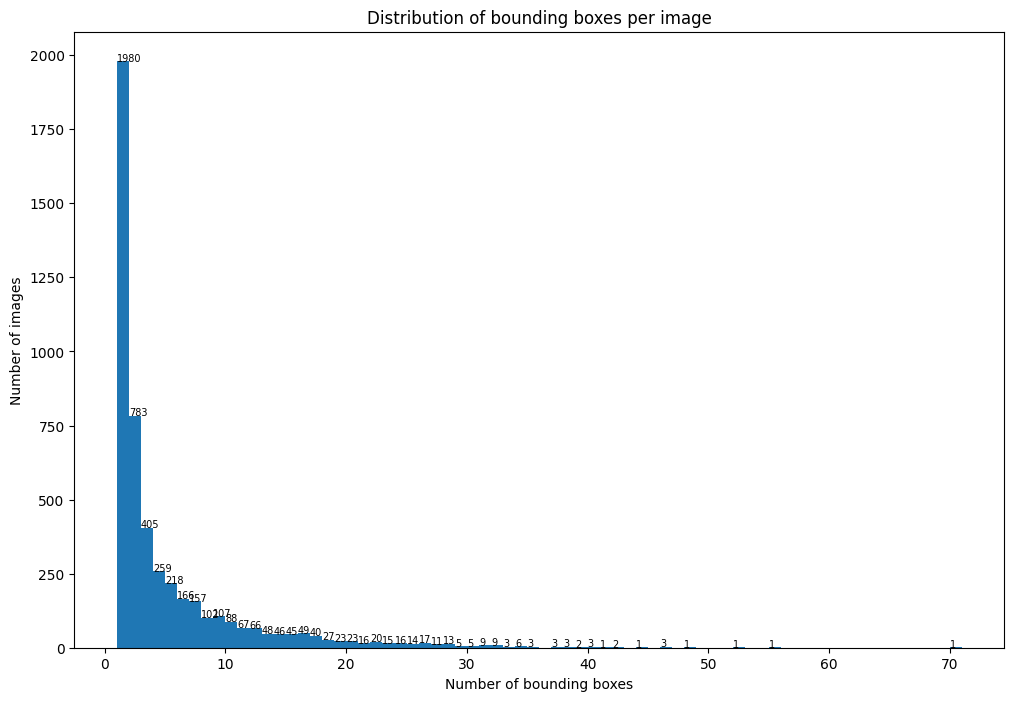

In [4]:
# 이미지마다 category_id가 몇 개 있는지 세보기
box_counts = df.groupby('image_id')['category_id'].count()
print("최소값:",box_counts.min(), "최대값:",box_counts.max())
plt.figure(figsize=(12,8))
n, bins, patches = plt.hist(box_counts, bins=70)
for i, num in enumerate(n):
    if num > 0:
        plt.text(bins[i], num, int(num), fontsize=7)
plt.xlabel('Number of bounding boxes')
plt.ylabel('Number of images')
plt.title('Distribution of bounding boxes per image')
plt.show()


In [5]:
## 30개의 Bbox가 있는 image_id 출력하기
bbox_30_ids = box_counts[box_counts == 30].index
print(bbox_30_ids)
bbox_52_ids = box_counts[box_counts == 52].index
print(bbox_52_ids)

Float64Index([321.0, 1002.0, 3135.0, 3716.0, 4537.0], dtype='float64', name='image_id')
Float64Index([4047.0], dtype='float64', name='image_id')


## Bbox 그리기

In [6]:
# 이미지에 Bbox 그리기
import cv2
import numpy as np

def visualize_bbox(img, bbox, color=(0, 255, 0), thickness=2):
    """
    img: numpy.ndarray, shape (H, W, C)
        이미지 데이터
    bbox: list
        bbox 정보 [x_min, y_min, x_max, y_max]
    color: tuple
        bbox 색상 (B, G, R)
    thickness: int
        bbox 두께
    """
    # bbox 정보 추출
    x_min, y_min, x_max, y_max = bbox

    # bbox 그리기
    img_bbox = cv2.rectangle(
        img, (x_min, y_min), (x_max, y_max), color, thickness)

    return img_bbox


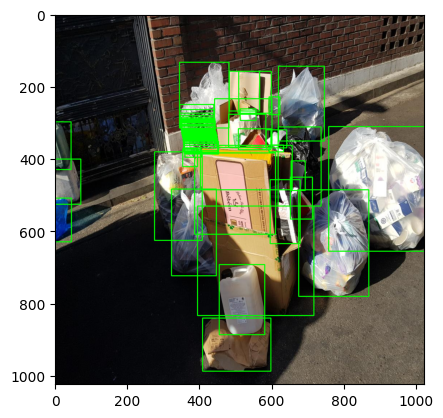

In [7]:
# 이미지 경로
image_dir = '/opt/ml/dataset/train/4047.jpg' #52개의 bbox를 가지고 있는 임의의 사진
bbox = df[df['image_id'] == 4047] #4047번 이미지의 bbox정보

# DataFrame 순회
image = cv2.imread(image_dir) #이미지 로드
for i in range(len(bbox)):
    x_min, y_min, w, h = bbox.iloc[i]['Xmin'], bbox.iloc[i]['Ymin'], bbox.iloc[i]['width'], bbox.iloc[i]['height'] # bbox 좌표값 추출
    x_max, y_max = x_min + w, y_min + h
    cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()


# 클래스  간 상관관계

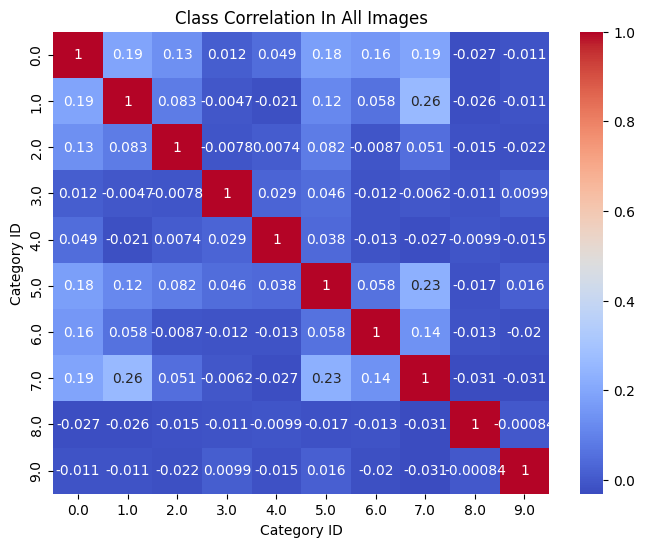

In [8]:
# 모든 이미지에 대한 상관관계
class_counts = df['category_id'].value_counts()
# 클래스 간의 상관 행렬 생성
correlation_matrix = df.groupby('image_id')['category_id'].value_counts().unstack(fill_value=0)
correlation_matrix = correlation_matrix.corr()
# 상관 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.xlabel('Category ID')
plt.ylabel('Category ID')
plt.title('Class Correlation In All Images')
plt.show()


# Bbox ratio

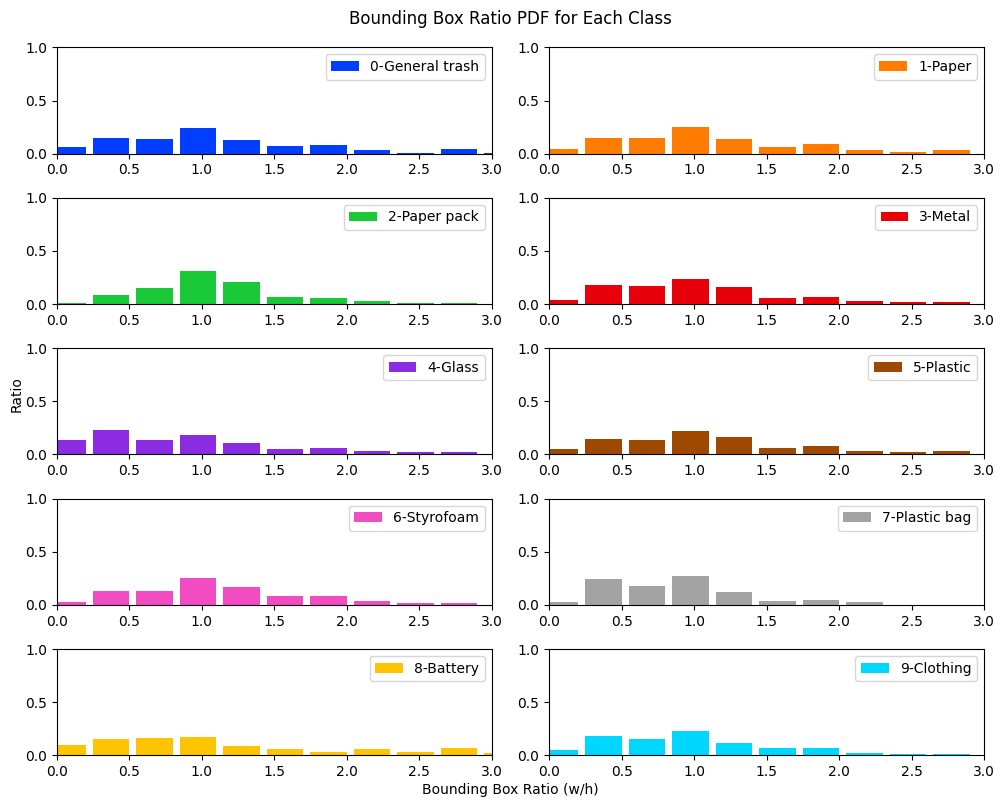

In [9]:

# 각 클래스별 bbox ratio 확인
ratio_count = df.groupby(['category_id',
'ratio']).size().reset_index(name='count')
# count_ratio 계산
class_counts = df['category_id'].value_counts()
ratio_count['count_ratio'] = ratio_count.apply(lambda row: round(row['count'] /
class_counts[int(row['category_id'])], 2), axis=1)
default_palette = sns.color_palette('bright')[:10]
fig, axs = plt.subplots(5, 2, figsize=(10, 8))
x_ticks = [i['name'] for i in json_data['categories']]
for category_id in range(10):
 category_data = ratio_count[ratio_count['category_id'] == category_id]
 # PDF 그래프
 pdf_data = pd.DataFrame({'ratio': np.arange(0, category_data['ratio'].max() +
0.3, 0.3)})
 pdf_data['pdf'] = pdf_data['ratio'].apply(lambda x:
category_data[category_data['ratio'] <= x]['count_ratio'].sum())
 pdf_data['pdf'] = pdf_data['pdf'] - pdf_data['pdf'].shift(1).fillna(0) # 누적이 아닌 차분 값 계산
 axs[category_id // 2, category_id % 2].bar(pdf_data['ratio']-0.35, pdf_data['pdf'], width=0.25, align='edge', color=default_palette[category_id], label=f'{category_id}-{x_ticks[category_id]}')

 axs[category_id // 2, category_id % 2].set_xlim(0, 3)
 axs[category_id // 2, category_id % 2].set_ylim(0, 1)
 axs[category_id // 2, category_id % 2].set_xlabel("")
 axs[category_id // 2, category_id % 2].set_ylabel("")
 axs[category_id // 2, category_id % 2].legend()
plt.suptitle('Bounding Box Ratio PDF for Each Class')
fig.text(0.5, 0.00, 'Bounding Box Ratio (w/h)', ha='center')
fig.text(0.0, 0.5, 'Ratio', va='center', rotation='vertical')
plt.tight_layout()
plt.show()




# object heatmap

100%|██████████| 23144/23144 [00:06<00:00, 3625.07it/s]


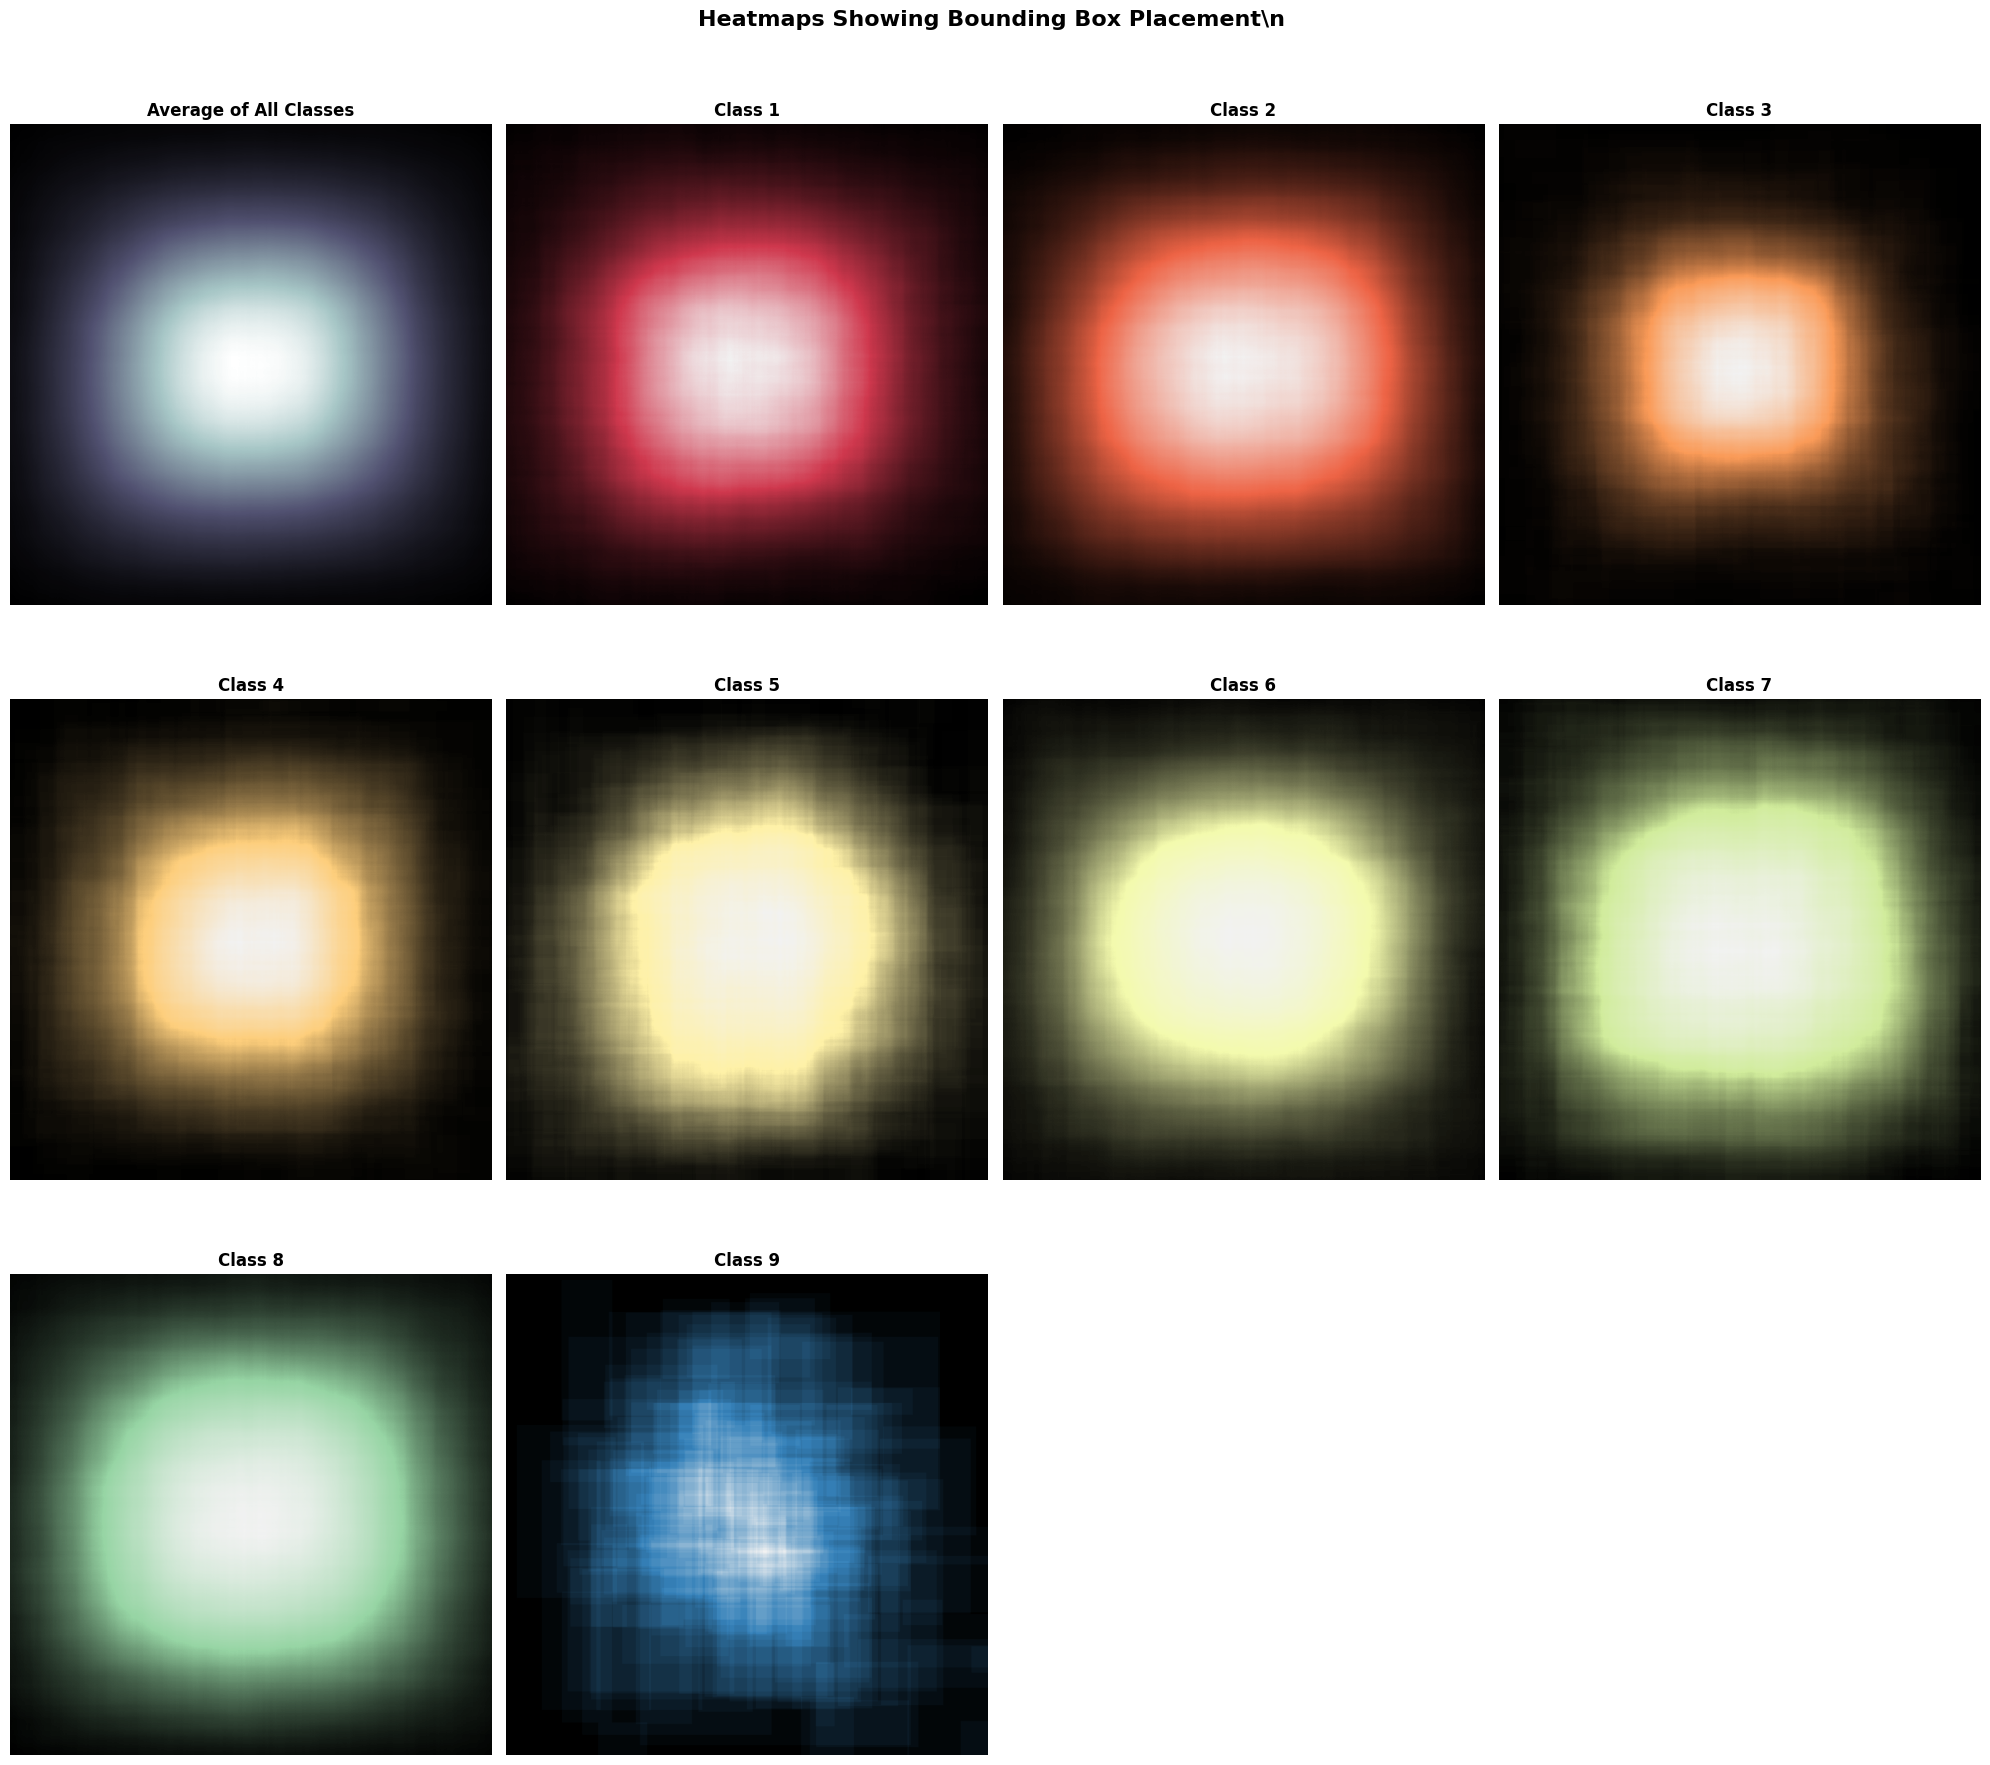

In [10]:
## object heatmap
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

bbox_df = pd.DataFrame(index=range(len(df['category_id'])), columns=['image_id', 'category_id', 'Xmin', 'Ymin', 'width', 'height', 'ratio', 'area'])

bbox_df['classid'] = df['category_id'].values
bbox_df['xmin'] = df['Xmin'].values
bbox_df['xmax'] = (df['Xmin'] + df['width']).values
bbox_df['ymin'] = df['Ymin'].values
bbox_df['ymax'] = (df['Ymin'] + df['height']).values
bbox_df['fracxmin'] = df['Xmin'].values / 1024
bbox_df['fracxmax'] = (df['Xmin'] + df['width']).values / 1024
bbox_df['fracymin'] = df['Ymin'].values / 1024
bbox_df['fracymax'] = (df['Ymin'] + df['height']).values / 1024

avesrcimg_height = 1024
avesrcimg_width = 1024

# DEFAULT
HEATMAP_SIZE = (avesrcimg_height, avesrcimg_width, 14)

# Initialize
heatmap = np.zeros((HEATMAP_SIZE), dtype=np.int16)
bboxnp = bbox_df[["classid", "fracxmin", "fracxmax", "fracymin", "fracymax"]].to_numpy()
bboxnp[:, 1:3] *= avesrcimg_width
bboxnp[:, 3:5] *= avesrcimg_height
bboxnp = np.floor(bboxnp).astype(np.int16)

# Color map stuff
custom_cmaps = [matplotlib.colors.LinearSegmentedColormap.from_list(colors=[(0.,0.,0.), c, (0.95,0.95,0.95)], name=f"custom{i}") for i,c in enumerate(sns.color_palette("Spectral", 10))]

custom_cmaps.pop(8) # Remove No-Finding

for row in tqdm(bboxnp, total=bboxnp.shape[0]):
    heatmap[row[3]:row[4]+1, row[1]:row[2]+1, row[0]] += 1

fig = plt.figure(figsize=(20,25))
plt.suptitle("Heatmaps Showing Bounding Box Placement\\n ", fontweight="bold", fontsize=16)

for i in range(10):
    plt.subplot(4, 4, i+1)
    if i==0:
        plt.imshow(heatmap.mean(axis=-1), cmap="bone")
        plt.title(f"Average of All Classes", fontweight="bold")
    else:
        plt.imshow(heatmap[:, :, i-1], cmap=custom_cmaps[i-1])
        plt.title(f"Class {i}", fontweight="bold")
    plt.axis(False)

fig.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


## 가장 작은 Bbox , 가장 큰 Bbox 확인하기

In [ ]:
box_size = ['s','m','l']
area_list = df['area']
print("최소값:",area_list.min(), "최대값:",area_list.max())

# 이미지 경로
min_area = df[df['area'] == 0.56]
max_area = df[df['area'] == 1048371.21]
min_area_img_dir = '/opt/ml/dataset/train/1063.jpg'
max_area_img_dir = '/opt/ml/dataset/train/1160.jpg'

# 이미지 내 Bbox 표기

def one_bbox(img_dir, df): # Bbox 하나만 출력
    image = cv2.imread(img_dir)
    bbox = df.iloc[0]
    x_min, y_min, w, h = bbox['Xmin'], bbox['Ymin'], bbox['width'], bbox['height']
    x_max, y_max = x_min + w, y_min + h
    cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 0, 255), 2)
    
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    
one_bbox(min_area_img_dir, min_area)
one_bbox(max_area_img_dir, max_area)

##  클래스별로 박스 크기 s,m,l 분포 확인하기

category_ids = sorted(df['category_id'].unique()) 
category_data = []
name_lst = ['General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']

# category_id 별로 데이터를 나눠서 리스트에 저장
for c_id in category_ids:
    bbox_data = df[df['category_id'] == c_id]
    category_data.append(bbox_data)

min_size = 32 * 32  # small 기준값
mid_size = 96 * 96  # medium 기준값
bbox_sizes = ['small', 'medium', 'large']
lst = []
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for i, bbox_data in enumerate(category_data):
    bbox_counts = [0, 0, 0] # 각 클래스에 대한 카운트 리스트 초기화
    for bbox in bbox_data['area']:
        if bbox < min_size:
            bbox_counts[0] += 1
        elif bbox < mid_size:
            bbox_counts[1] += 1
        else:
            bbox_counts[2] += 1
    lst.append([name_lst[i], bbox_counts])
    row_idx = i // 5
    col_idx = i % 5
    ax = axes[row_idx, col_idx]
    sns.barplot(x=bbox_sizes, y=bbox_counts, ax=ax)
    ax.set_title(name_lst[i])
    for j, v in enumerate(bbox_counts):
        ax.text(j, v, str(v), color='black', ha="center")

plt.tight_layout()
plt.show()
#print(*lst, sep='\n')

![Untitled](https://s3-us-west-2.amazonaws.com/secure.notion-static.com/e0dd15c4-7a89-4a60-b76a-77e46f9a3ca2/Untitled.png)